# Nearest Neighbors

The Nearest Neighbors algorith predicts a class of a given entry by polling the n closest points defined by some heuristic (in this case euclidean distance) and decides by a relative majority vote. To put it in layman terms, a new point is assumed to be similar to the majority of points on its surrounding.

In [1]:
import numpy as np
import heapq

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from support import ClusteredDataset, Colors

In [2]:
class NearestNeighbors:
    # Support class.
    # Pair of numbers (ID and value) that are comparable by value
    class __Pair:
        def __init__(self,ID,value):
            self.ID = ID
            self.value = value
        
        # Since I am using the built-in min-heap to 
        # keep track of the distances, the easiest way
        # to convert that to a max heap is to invert
        # the comparisons 
        def __lt__(self, other):
            return self.value > other.value
        
        def __eq__(self, other):
            return self.value == other.value
        
        def __gt__(self, other):
            return self.value < other.value
        
        def __str__(self):
            return "<{},{}>".format(self.ID,self.value)
        
        def __repr__(self):
            return str(self)
    
    # Define and lock private variables
    __slots__ = ["__X", "__y"]    
    
    # Initialize the class with the appropiate training data and labels
    def __init__(self, X, y):
        if not self.__valid_x(X):
            return
        
        if not self.__valid_y(y):
            return
        
        if np.shape(X)[0] != np.shape(y)[0]:
            raise ValueError("Both inputs must have the same number of entries.")
            return
        
        self.__X = np.array(X)
        self.__y = np.array(y)
    
    # Check if a dataset is valid
    def __valid_x(self, X):
        # Check if X is a vector or a matrix
        if np.isscalar(X) or len(np.shape(X)) > 2:
            raise ValueError("The first input must be a vector or a matrix.")
            return False
        
        return True
    
    # Check if a label vector is valid
    def __valid_y(self, y):
        # Check if y is a vector or a matrix-like
        if np.isscalar(y) or len(np.shape(y)) > 2:
            raise ValueError("The second input must be a vector.")
            return False
        
        # if y is a matrix-like, ensure it is a column vector
        if len(np.shape(y)) == 2 and np.shape(y)[1] != 1:
            raise ValueError("The second input must be a vector.")
            return False
        
        return True           
        
    
    # predict the label for a single entry using n neighbors
    def __predict_label(self, entry, neighbors):
        best_points = []
        
        # Get the N closest neighboring points
        for i,x in enumerate(self.__X):
            pair = self.__Pair(i,np.linalg.norm(x-entry))
            
            #print("=============")
            #print(pair)
            #if len(best_points) > 0:
            #    print(best_points[0])
            
            if len(best_points) < neighbors:
                heapq.heappush(best_points, pair)
                heapq.heapify(best_points)
                
            elif pair.value < best_points[0].value:
                #_ = heapq.heapreplace(best_points, pair)
                
                _ = heapq.heappop(best_points)
                heapq.heappush(best_points, pair)
            
            #print(best_points)
        
        # Extract the ID's from the list of closest points
        IDs = []
        for b in best_points:
            IDs.append(b.ID)
        
        #print(best_points)
        #print(y[IDs])
        # return the most repeated label 
        # in the list of closest points
        return np.argmax(np.bincount(y[IDs]))
    
    
    # predict labels for a dataset using n neighbors
    def predict(self, X, neighbors):
        # Check if "neighbors" is a valid number (positive scalar)
        if not np.isscalar(neighbors) or neighbors < 1:
            raise ValueError("Invalid value for neighbors.")
            return            
        
        if not self.__valid_x(X):
            return
        
        # Check that the input has the appropiate number of features
        if np.shape(X)[-1] != np.shape(self.__X)[-1]:
            raise ValueError("Each input must have {} features.".format(np.shape(self.__X)[-1]))
            return
        
        # Convert input into a numpy matrix
        if len(np.shape(X)) == 1:
            X = np.array([X])
        else:
            X = np.array(X)
        
        labels = []
        for entry in X:
            labels.append(self.__predict_label(entry, neighbors))
        
        return labels        

In [3]:
# Support functions

# Get the center of the whole test dataset and its spread
def TestArgs(groups):
    out_max = -float('Inf') * np.ones_like(groups[0][1])
    out_min = float('Inf') * np.ones_like(groups[0][1])
    
    for g in groups:
        for i,x in enumerate(g[1]):
            if x > out_max[i]:
                out_max[i] = x
            if x < out_min[i]:
                out_min[i] = x
    
    return (out_max + out_min) / 2, out_min, out_max
    

## Example

In [4]:
# Define how many groups of data should be
# generated for the training set
# (number_of_points, center)
groups = (
    (20, [40,0]), 
    (15, [ 45,0]), 
    ( 3, [ 43,5])
)

# Define the number of points to generate
# on the test dataset
test_size = 35

### Generate training dataset

To view how the algorithm works, first we will generate a training dataset by creating clusters of points of the same type.

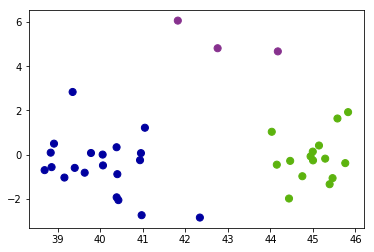

In [5]:
X,y = ClusteredDataset(*groups)

#X = np.vstack( (GenerateSet(type_a_points, [-2,0]), generate_set(type_b_points,[2,0])) ) 
#y = np.array(([0]*type_a_points) + ([1]*type_b_points))
plt.scatter(X[:,0], X[:,1], c=Colors(y), s=50)
plt.show()

### Generating Test data

To check how the algorithm assings labels to new points, we will create a cloud of points on our workspace.

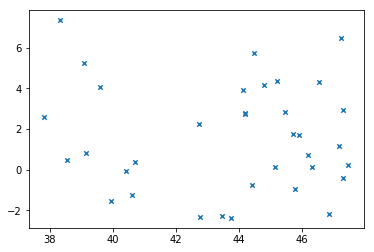

In [6]:
# Get a properly shaped random dataset with values [-0.5, 0.5)
rng = 2*np.random.random(size=(test_size, np.shape(X)[-1] )) - 1

group_center, group_min, group_max  = TestArgs(groups)
group_spread = group_max - group_min

test = (group_spread * rng) + group_center
plt.scatter(test[:,0], test[:,1], marker='x', s=20)
plt.show()

### Predictions by number of neighbors

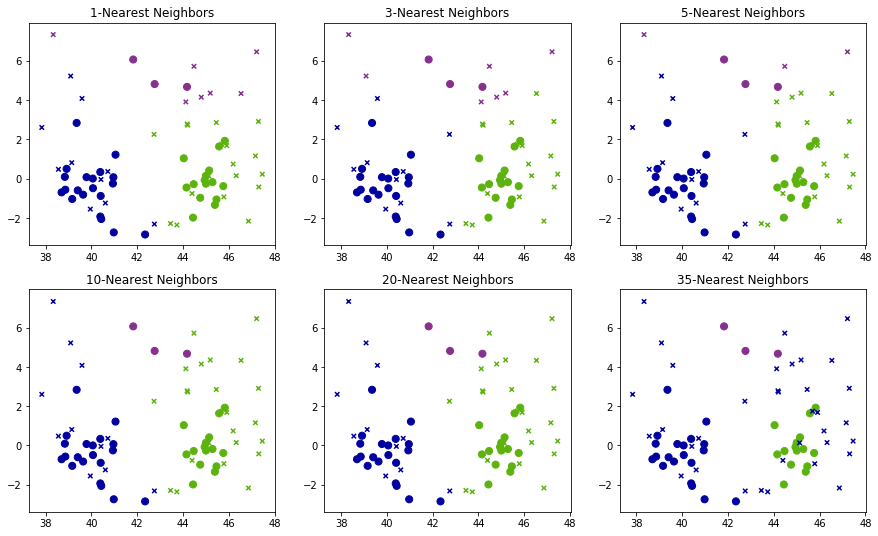

In [7]:
nn = NearestNeighbors(X, y)
examples = [1,3,5,10,20,test.shape[0]]

plt.figure(figsize=(15,9))
for i,e in enumerate(examples):
    predict = nn.predict(test,e)

    ID = 230 + i + 1
    ax = plt.subplot(ID)
    ax.set_title("{}-Nearest Neighbors".format(e))
    ax.scatter(X[:,0], X[:,1], c=Colors(y), s=50)
    ax.scatter(test[:,0], test[:,1], marker='x', c=Colors(predict), s=20)
plt.show()

### Boundaries by number of neighbors

Here, we can see how the workspace gets divided depending on the number of neighbors we are considering.

As the number gets large, the smaller clusters loose all power to affect how labels get assigned as they get overpowered in every vote. 

In the extreme where we consider all points, any entry will be assigned to the bigger cluster as they hold the plurality, thus the worspace gets only a single colour.

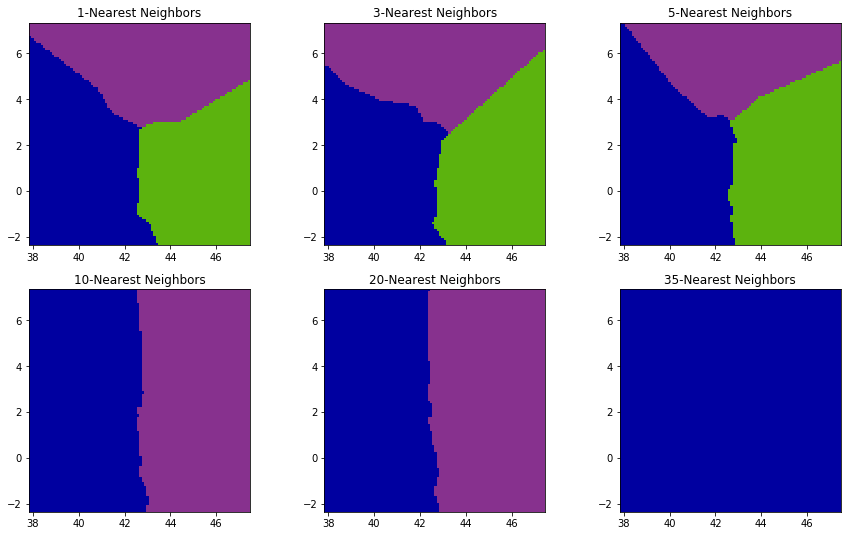

In [8]:
def NearestSpace(nn, neighbors, center, mins, maxs, x_dim, y_dim, step=0.1):

    x_min, x_max = mins[x_dim], maxs[x_dim]
    y_min, y_max = mins[y_dim], maxs[y_dim]
    x_steps, y_steps = int((x_max-x_min)/step), int((y_max-y_min)/step)
        
    labels = []
    for i in range(x_steps):
        x = x_min + i * step
        entries = []
        for j in range(y_steps):
            y = y_min + j * step
            entry = np.array(center)
            entry[x_dim] = x
            entry[y_dim] = y
            entries.append(entry)
        z = nn.predict(entries,neighbors)       
        labels.append(z)

    return (np.array(labels)[:,:]).transpose(), [x_min, x_max, y_min, y_max]


c_values = Colors(set(y.flatten()))
my_cmap = ListedColormap(c_values, 'myCmap')

"""
segments, extent = NearestSpace(nn, 1, group_center, test.min(axis=0), test.max(axis=0), 0, 1, 0.075)
ax = plt.subplot(111)
ax.imshow(segments, extent=extent, origin='lower', cmap=my_cmap)
plt.show()
"""
plt.figure(figsize=(15,9))
for i,e in enumerate(examples):
    segments, extent = NearestSpace(nn, e, group_center, test.min(axis=0), test.max(axis=0), 0, 1, 0.1)

    ID = 230 + i + 1
    ax = plt.subplot(ID)
    ax.set_title("{}-Nearest Neighbors".format(e))
    ax.imshow(segments, extent=extent, origin='lower', cmap=my_cmap)
plt.show()
